In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycaret

In [2]:
ambient_dataset = pd.read_csv("ambient_temperature_system_failure.csv")

In [3]:
# To create an extra feature for Holidays

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start=ambient_dataset['timestamp'].min(),
                        end=ambient_dataset['timestamp'].max()).to_pydatetime()

In [4]:
ambient_dataset

timestamp      value
0     2013-07-04 00:00:00  69.880835
1     2013-07-04 01:00:00  71.220227
2     2013-07-04 02:00:00  70.877805
3     2013-07-04 03:00:00  68.959400
4     2013-07-04 04:00:00  69.283551
...                   ...        ...
7262  2014-05-28 11:00:00  72.370206
7263  2014-05-28 12:00:00  72.172956
7264  2014-05-28 13:00:00  72.046565
7265  2014-05-28 14:00:00  71.825226
7266  2014-05-28 15:00:00  72.584089

[7267 rows x 2 columns]

In [5]:
# Basic Statisitics for Tempreature value in the dataset

ambient_dataset.describe()

value
count  7267.000000
mean     71.242433
std       4.247509
min      57.458406
25%      68.369411
50%      71.858493
75%      74.430958
max      86.223213

In [6]:
ambient_dataset.dtypes

timestamp     object
value        float64
dtype: object

In [7]:
# Convert to Timestamp
ambient_dataset.timestamp = pd.to_datetime(ambient_dataset.timestamp)

In [8]:
ambient_dataset

timestamp      value
0    2013-07-04 00:00:00  69.880835
1    2013-07-04 01:00:00  71.220227
2    2013-07-04 02:00:00  70.877805
3    2013-07-04 03:00:00  68.959400
4    2013-07-04 04:00:00  69.283551
...                  ...        ...
7262 2014-05-28 11:00:00  72.370206
7263 2014-05-28 12:00:00  72.172956
7264 2014-05-28 13:00:00  72.046565
7265 2014-05-28 14:00:00  71.825226
7266 2014-05-28 15:00:00  72.584089

[7267 rows x 2 columns]

In [9]:
ambient_dataset.isna().any().any()
# No NaNs in the dataset 


False

Exploratory Data Analysis and Feature Engineering


In [10]:
# Feature Engineering to get extra features for EDA

ambient_dataset['Year'] = ambient_dataset['timestamp'].dt.year
ambient_dataset['Month'] = ambient_dataset['timestamp'].dt.month
ambient_dataset['Day'] = ambient_dataset['timestamp'].dt.day
ambient_dataset['Hour'] = ambient_dataset['timestamp'].dt.hour
ambient_dataset['weekday'] = ambient_dataset['timestamp'].dt.weekday
ambient_dataset['morning'] = (ambient_dataset['Hour'] >= 6) & (ambient_dataset['Hour'] <= 18)
ambient_dataset['working_day'] = (ambient_dataset['Day'] >= 0) & (ambient_dataset['Day'] <= 4)
ambient_dataset['holiday'] = ambient_dataset['timestamp'].dt.date.astype('datetime64').isin(holidays)

In [11]:
ambient_dataset

timestamp      value  Year  Month  Day  Hour  weekday  morning  \
0    2013-07-04 00:00:00  69.880835  2013      7    4     0        3    False   
1    2013-07-04 01:00:00  71.220227  2013      7    4     1        3    False   
2    2013-07-04 02:00:00  70.877805  2013      7    4     2        3    False   
3    2013-07-04 03:00:00  68.959400  2013      7    4     3        3    False   
4    2013-07-04 04:00:00  69.283551  2013      7    4     4        3    False   
...                  ...        ...   ...    ...  ...   ...      ...      ...   
7262 2014-05-28 11:00:00  72.370206  2014      5   28    11        2     True   
7263 2014-05-28 12:00:00  72.172956  2014      5   28    12        2     True   
7264 2014-05-28 13:00:00  72.046565  2014      5   28    13        2     True   
7265 2014-05-28 14:00:00  71.825226  2014      5   28    14        2     True   
7266 2014-05-28 15:00:00  72.584089  2014      5   28    15        2     True   

      working_day  holiday  
0            True     True  
1            True     True  
2            True     True  
3            True     True  
4            True     True  
...           ...      ...  
7262        False    False  
7263        False    False  
7264        False    False  
7265        False    False  
7266        False    False  

[7267 rows x 10 columns]

In [12]:
# Exploratory Data Analysis!

# The data has dates between 2013-07-04 -> 2014-05-27  + 2014-05-28 15 hours of data
# So 328 days, implying 7848 records should be there, implying missing hourly data for some dates or possible dates itself

# 7872 should be the total = (7267-16) + 621 
# 621 rows of data is missing => Almost 26 Days of Data is missing!

In [13]:
# Lets find those missing values!
# Resampling Hourly to find the missing values

ambient_dataset = ambient_dataset.set_index('timestamp')
ambient_dataset_sampled = ambient_dataset.reindex(pd.date_range(start = ambient_dataset.index[0], end=ambient_dataset.index[-1], freq='H'))




In [14]:
ambient_dataset_sampled

value    Year  Month   Day  Hour  weekday morning  \
2013-07-04 00:00:00  69.880835  2013.0    7.0   4.0   0.0      3.0   False   
2013-07-04 01:00:00  71.220227  2013.0    7.0   4.0   1.0      3.0   False   
2013-07-04 02:00:00  70.877805  2013.0    7.0   4.0   2.0      3.0   False   
2013-07-04 03:00:00  68.959400  2013.0    7.0   4.0   3.0      3.0   False   
2013-07-04 04:00:00  69.283551  2013.0    7.0   4.0   4.0      3.0   False   
...                        ...     ...    ...   ...   ...      ...     ...   
2014-05-28 11:00:00  72.370206  2014.0    5.0  28.0  11.0      2.0    True   
2014-05-28 12:00:00  72.172956  2014.0    5.0  28.0  12.0      2.0    True   
2014-05-28 13:00:00  72.046565  2014.0    5.0  28.0  13.0      2.0    True   
2014-05-28 14:00:00  71.825226  2014.0    5.0  28.0  14.0      2.0    True   
2014-05-28 15:00:00  72.584089  2014.0    5.0  28.0  15.0      2.0    True   

                    working_day holiday  
2013-07-04 00:00:00        True    True  
2013-07-04 01:00:00        True    True  
2013-07-04 02:00:00        True    True  
2013-07-04 03:00:00        True    True  
2013-07-04 04:00:00        True    True  
...                         ...     ...  
2014-05-28 11:00:00       False   False  
2014-05-28 12:00:00       False   False  
2014-05-28 13:00:00       False   False  
2014-05-28 14:00:00       False   False  
2014-05-28 15:00:00       False   False  

[7888 rows x 9 columns]

In [15]:
# These are the missing rows or timestamps with no value not present in the original dataset

ambient_dataset_sampled[ambient_dataset_sampled['value'].isnull()]

#2013-07-04 -> 2014-05-27  + 2014-05-28 15 hours of data


value  Year  Month  Day  Hour  weekday morning  \
2013-07-28 02:00:00    NaN   NaN    NaN  NaN   NaN      NaN     NaN   
2013-07-28 05:00:00    NaN   NaN    NaN  NaN   NaN      NaN     NaN   
2013-07-28 06:00:00    NaN   NaN    NaN  NaN   NaN      NaN     NaN   
2013-07-28 07:00:00    NaN   NaN    NaN  NaN   NaN      NaN     NaN   
2013-07-28 08:00:00    NaN   NaN    NaN  NaN   NaN      NaN     NaN   
...                    ...   ...    ...  ...   ...      ...     ...   
2014-04-10 10:00:00    NaN   NaN    NaN  NaN   NaN      NaN     NaN   
2014-04-10 11:00:00    NaN   NaN    NaN  NaN   NaN      NaN     NaN   
2014-04-10 12:00:00    NaN   NaN    NaN  NaN   NaN      NaN     NaN   
2014-04-10 13:00:00    NaN   NaN    NaN  NaN   NaN      NaN     NaN   
2014-04-10 14:00:00    NaN   NaN    NaN  NaN   NaN      NaN     NaN   

                    working_day holiday  
2013-07-28 02:00:00         NaN     NaN  
2013-07-28 05:00:00         NaN     NaN  
2013-07-28 06:00:00         NaN     NaN  
2013-07-28 07:00:00         NaN     NaN  
2013-07-28 08:00:00         NaN     NaN  
...                         ...     ...  
2014-04-10 10:00:00         NaN     NaN  
2014-04-10 11:00:00         NaN     NaN  
2014-04-10 12:00:00         NaN     NaN  
2014-04-10 13:00:00         NaN     NaN  
2014-04-10 14:00:00         NaN     NaN  

[621 rows x 9 columns]

In [16]:
ambient_dataset

value  Year  Month  Day  Hour  weekday  morning  \
timestamp                                                                  
2013-07-04 00:00:00  69.880835  2013      7    4     0        3    False   
2013-07-04 01:00:00  71.220227  2013      7    4     1        3    False   
2013-07-04 02:00:00  70.877805  2013      7    4     2        3    False   
2013-07-04 03:00:00  68.959400  2013      7    4     3        3    False   
2013-07-04 04:00:00  69.283551  2013      7    4     4        3    False   
...                        ...   ...    ...  ...   ...      ...      ...   
2014-05-28 11:00:00  72.370206  2014      5   28    11        2     True   
2014-05-28 12:00:00  72.172956  2014      5   28    12        2     True   
2014-05-28 13:00:00  72.046565  2014      5   28    13        2     True   
2014-05-28 14:00:00  71.825226  2014      5   28    14        2     True   
2014-05-28 15:00:00  72.584089  2014      5   28    15        2     True   

                     working_day  holiday  
timestamp                                  
2013-07-04 00:00:00         True     True  
2013-07-04 01:00:00         True     True  
2013-07-04 02:00:00         True     True  
2013-07-04 03:00:00         True     True  
2013-07-04 04:00:00         True     True  
...                          ...      ...  
2014-05-28 11:00:00        False    False  
2014-05-28 12:00:00        False    False  
2014-05-28 13:00:00        False    False  
2014-05-28 14:00:00        False    False  
2014-05-28 15:00:00        False    False  

[7267 rows x 9 columns]

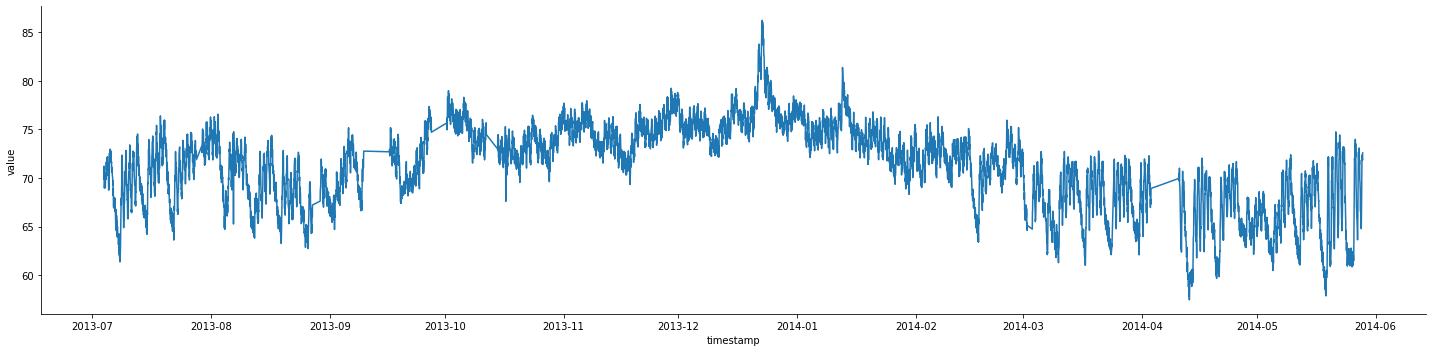

In [17]:
# Simple Time Series Line Plot
sns.relplot(x = ambient_dataset.index, y='value',aspect=4,kind='line',data=ambient_dataset)

In [18]:
# Interesting to note the tempreature flucutaes up and down in cycles within each month

In [19]:
# Looking at Daily Minimum Values
ambient_dataset_byday_min = ambient_dataset.resample('D').min()


In [20]:
# Looking at Daily Maximum Values
ambient_dataset_byday_max = ambient_dataset.resample('D').max()


In [21]:
# Looking at Daily Average Values
ambient_dataset_byday_average = ambient_dataset.resample('D').mean()


In [22]:
# A logic check nothing more
#ambient_dataset[0:24]['value'].sum()/24

(array([15887., 15918., 15949., 15979., 16010., 16040., 16071., 16102.,
        16130., 16161., 16191., 16222.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

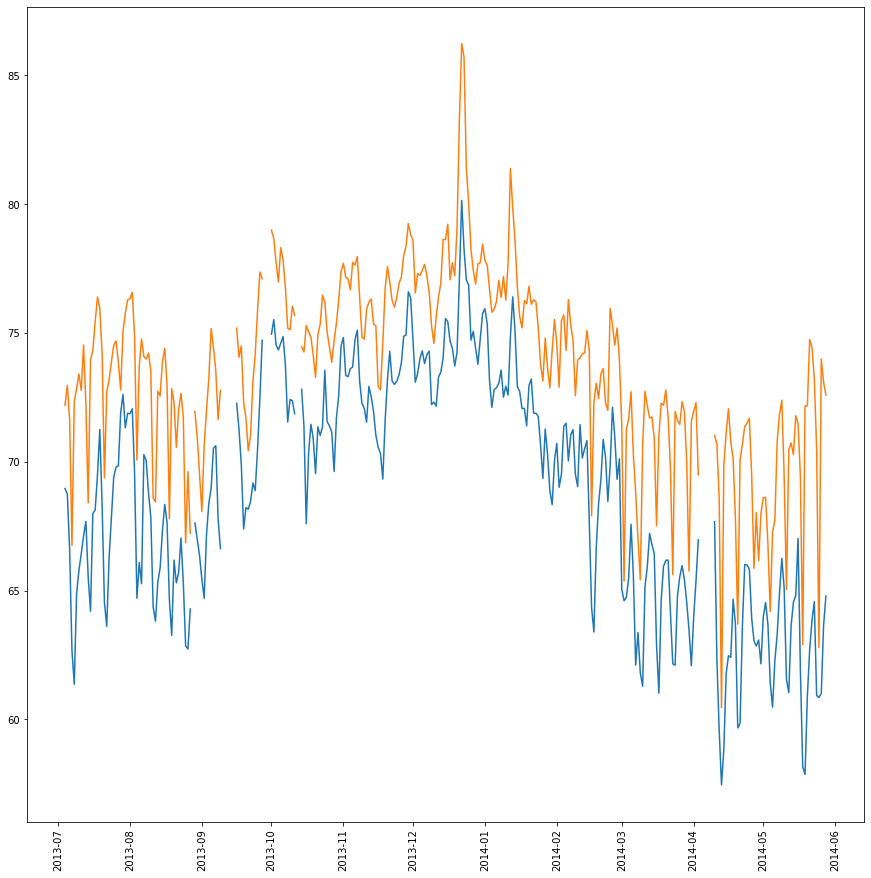

In [23]:
# Line Plots to see how the minimum and maximum values fluctuated separately

fig,ax = plt.subplots(figsize=(15,15))
ax.plot(ambient_dataset_byday_min.index,ambient_dataset_byday_min.value)
ax.plot(ambient_dataset_byday_max.index,ambient_dataset_byday_max.value)
plt.xticks(rotation=90)



In [24]:
# Just Looking at daily average tempreatures over the timeline 
ambient_dataset_byday_average

value    Year  Month   Day  Hour  weekday   morning  \
timestamp                                                             
2013-07-04  70.470846  2013.0    7.0   4.0  11.5      3.0  0.541667   
2013-07-05  71.352607  2013.0    7.0   5.0  11.5      4.0  0.541667   
2013-07-06  68.720375  2013.0    7.0   6.0  11.5      5.0  0.541667   
2013-07-07  64.706808  2013.0    7.0   7.0  11.5      6.0  0.541667   
2013-07-08  66.316833  2013.0    7.0   8.0  11.5      0.0  0.541667   
...               ...     ...    ...   ...   ...      ...       ...   
2014-05-24  63.616840  2014.0    5.0  24.0  11.5      5.0  0.541667   
2014-05-25  61.843362  2014.0    5.0  25.0  11.5      6.0  0.541667   
2014-05-26  67.556544  2014.0    5.0  26.0  11.5      0.0  0.541667   
2014-05-27  69.006403  2014.0    5.0  27.0  11.5      1.0  0.541667   
2014-05-28  68.699634  2014.0    5.0  28.0   7.5      2.0  0.625000   

            working_day  holiday  
timestamp                         
2013-07-04          1.0      1.0  
2013-07-05          0.0      0.0  
2013-07-06          0.0      0.0  
2013-07-07          0.0      0.0  
2013-07-08          0.0      0.0  
...                 ...      ...  
2014-05-24          0.0      0.0  
2014-05-25          0.0      0.0  
2014-05-26          0.0      1.0  
2014-05-27          0.0      0.0  
2014-05-28          0.0      0.0  

[329 rows x 9 columns]

In [25]:
#data = pd.Series(ambient_dataset_byday_average.value)

In [26]:
#data

<AxesSubplot:xlabel='timestamp'>

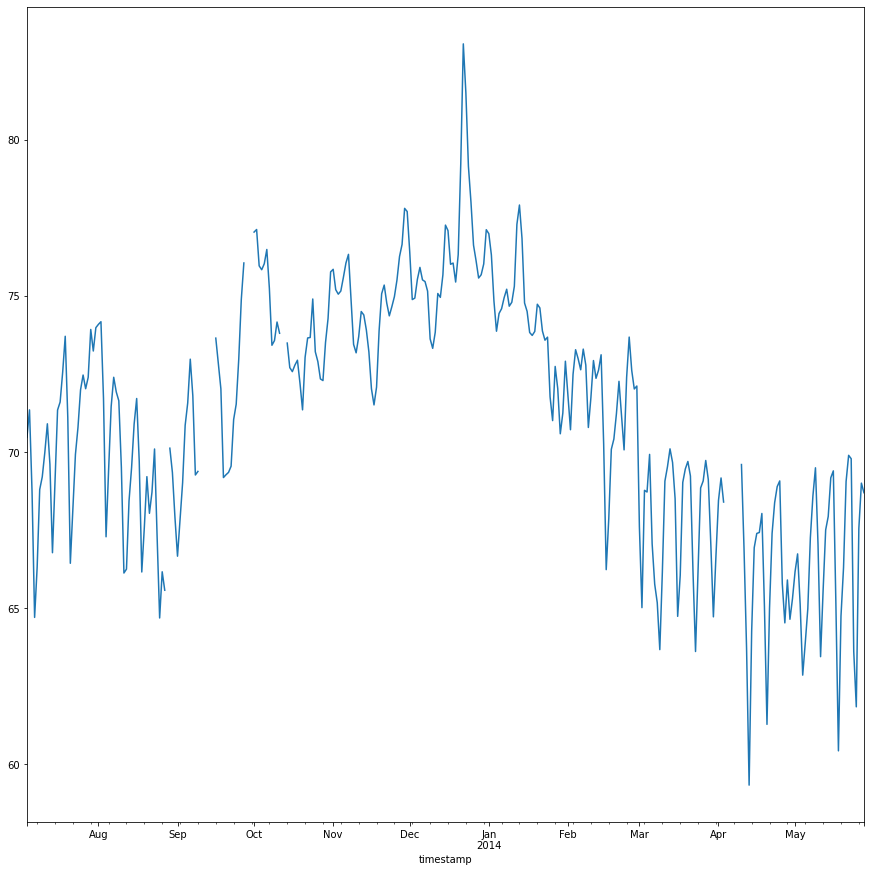

In [27]:
# Simple Line Plot to see the daily average Tempreatures 
ambient_dataset_byday_average['value'].plot(figsize=(15,15))


In [28]:
# Interesting Insight: The Daily mean tempreature value has increased from July 4th to the end of December and it has  
# decreased from January to end of May
# Good to think of the changes in rationale against regular seasons of fall,winter and spring

(array([15887., 15918., 15949., 15979., 16010., 16040., 16071., 16102.,
        16130., 16161., 16191., 16222.]),
 [Text(15887.0, 0, '2013-07'),
  Text(15918.0, 0, '2013-08'),
  Text(15949.0, 0, '2013-09'),
  Text(15979.0, 0, '2013-10'),
  Text(16010.0, 0, '2013-11'),
  Text(16040.0, 0, '2013-12'),
  Text(16071.0, 0, '2014-01'),
  Text(16102.0, 0, '2014-02'),
  Text(16130.0, 0, '2014-03'),
  Text(16161.0, 0, '2014-04'),
  Text(16191.0, 0, '2014-05'),
  Text(16222.0, 0, '2014-06')])

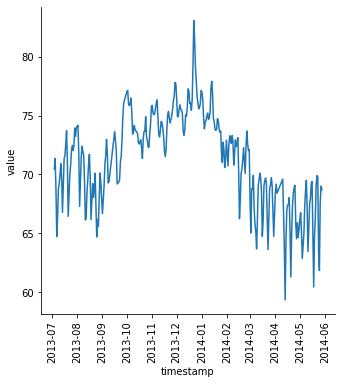

In [29]:
# Just a smaller seaborn plot

sns.relplot(x = ambient_dataset_byday_average.index, y = 'value', data = ambient_dataset_byday_average,kind = 'line',aspect=1 )
plt.xticks(rotation=90)


In [30]:
# For the time series data, there exsists the trends, seasons and noise
# Lets decompose the time series plot to look at Trends, Errors and Seasonality : Need more time for this :-)

#from statsmodels.tsa.seasonal import seasonal_decompose
#result = seasonal_decompose(ambient_dataset_byday_average['value'].values,model='multiplicative')
#result.plot()

<AxesSubplot:xlabel='Month', ylabel='value'>

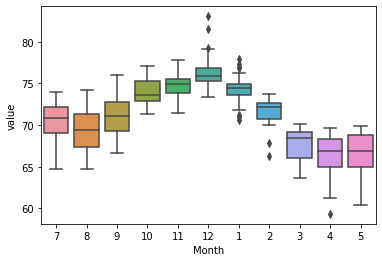

In [31]:
# Lets look at the average tempreature box plots over the timelines too
order_months = [7,8,9,10,11,12,1,2,3,4,5]
sns.boxplot(x = "Month", y = 'value', data = ambient_dataset_byday_average,order=order_months)


In [32]:
# Intersting to see the 25%-75% Quartile ranges are longer from July to December and March to May compared to the colder months
# Hotter months have greater widths 

# Most Intersting are the Outliers(Anomalies) easily seen for December, January,Febraury in prominance
# There are also anomalies for April

C:\Users\18136\anaconda38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value'>

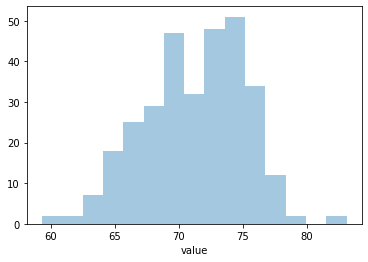

In [33]:
# Historgam to see the distribution of Tempreatures by Buckets 
sns.distplot(ambient_dataset_byday_average['value'],kde=False)

<AxesSubplot:xlabel='value', ylabel='Density'>

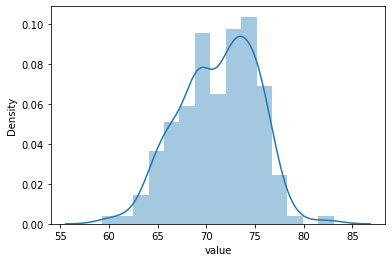

In [34]:
# Looking at the KDE Plot to understand the nature of distribution
sns.distplot(ambient_dataset_byday_average['value'],kde=True)
# Looks like a Gaussian Distribution

In [35]:
# Looking at new Features created

In [36]:
# Weekdays VS Weekends

ambient_dataset_weekday = ambient_dataset[ambient_dataset['working_day']==True]
ambient_dataset_weekend = ambient_dataset[ambient_dataset['working_day']==False]

In [37]:
ambient_dataset_weekday_avg = ambient_dataset_weekday.resample('D').mean()
ambient_dataset_weekend_avg = ambient_dataset_weekend.resample('D').mean()


<AxesSubplot:xlabel='Month', ylabel='value'>

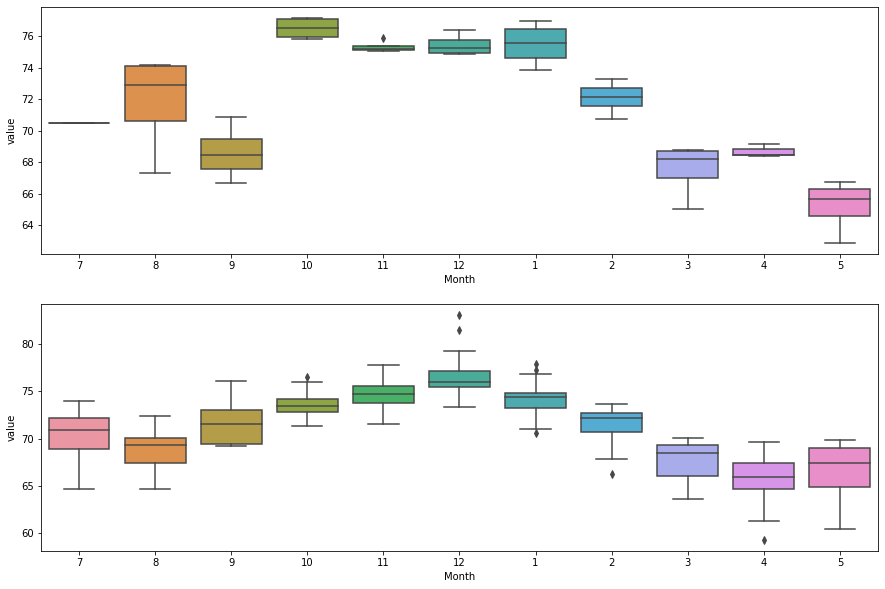

In [38]:
order_months = [7,8,9,10,11,12,1,2,3,4,5]

fig, axes =fig,ax = plt.subplots(2,1, figsize=(15,10))
sns.boxplot(x = "Month", y = 'value', data = ambient_dataset_weekday_avg,order=order_months,ax = axes[0])
sns.boxplot(x = "Month", y = 'value', data = ambient_dataset_weekend_avg,order=order_months,ax = axes[1])



In [39]:
# Anomaly Detection Machine Learning Modelling:
ambient_dataset

value  Year  Month  Day  Hour  weekday  morning  \
timestamp                                                                  
2013-07-04 00:00:00  69.880835  2013      7    4     0        3    False   
2013-07-04 01:00:00  71.220227  2013      7    4     1        3    False   
2013-07-04 02:00:00  70.877805  2013      7    4     2        3    False   
2013-07-04 03:00:00  68.959400  2013      7    4     3        3    False   
2013-07-04 04:00:00  69.283551  2013      7    4     4        3    False   
...                        ...   ...    ...  ...   ...      ...      ...   
2014-05-28 11:00:00  72.370206  2014      5   28    11        2     True   
2014-05-28 12:00:00  72.172956  2014      5   28    12        2     True   
2014-05-28 13:00:00  72.046565  2014      5   28    13        2     True   
2014-05-28 14:00:00  71.825226  2014      5   28    14        2     True   
2014-05-28 15:00:00  72.584089  2014      5   28    15        2     True   

                     working_day  holiday  
timestamp                                  
2013-07-04 00:00:00         True     True  
2013-07-04 01:00:00         True     True  
2013-07-04 02:00:00         True     True  
2013-07-04 03:00:00         True     True  
2013-07-04 04:00:00         True     True  
...                          ...      ...  
2014-05-28 11:00:00        False    False  
2014-05-28 12:00:00        False    False  
2014-05-28 13:00:00        False    False  
2014-05-28 14:00:00        False    False  
2014-05-28 15:00:00        False    False  

[7267 rows x 9 columns]

In [43]:
from pycaret.anomaly import *

ambient_dataset['MA24'] = ambient_dataset['value'].rolling(24).mean() # Daily Moving Average
ambient_dataset['MA168'] = ambient_dataset['value'].rolling(168).mean() # Weekly Moving Average

# Interactive Plotly plot

import plotly.express as px
fig = px.line(ambient_dataset, x=ambient_dataset.index, y=['value', 'MA24', 'MA168'], title='Tempreature Analysis', template = 'plotly')
fig.show()

In [44]:
# Using relevant features for model training

ambient_dataset.drop(['Month','working_day','morning','holiday'], axis=1, inplace=True)
ambient_dataset.drop(['Year'], axis=1, inplace=True)
ambient_dataset.drop(['MA24', 'MA168'], axis=1, inplace=True)
ambient_dataset.drop(['weekday'], axis=1, inplace=True)


In [45]:

ambient_dataset['day_of_year'] = [i.dayofyear for i in ambient_dataset.index]
ambient_dataset['day_name'] = [i.day_name() for i in ambient_dataset.index]
ambient_dataset['week_of_year'] = [i.weekofyear for i in ambient_dataset.index]
ambient_dataset['is_weekday'] = [i.isoweekday() for i in ambient_dataset.index]


In [46]:
ambient_dataset.head()

value  Day  Hour  day_of_year  day_name  \
timestamp                                                          
2013-07-04 00:00:00  69.880835    4     0          185  Thursday   
2013-07-04 01:00:00  71.220227    4     1          185  Thursday   
2013-07-04 02:00:00  70.877805    4     2          185  Thursday   
2013-07-04 03:00:00  68.959400    4     3          185  Thursday   
2013-07-04 04:00:00  69.283551    4     4          185  Thursday   

                     week_of_year  is_weekday  
timestamp                                      
2013-07-04 00:00:00            27           4  
2013-07-04 01:00:00            27           4  
2013-07-04 02:00:00            27           4  
2013-07-04 03:00:00            27           4  
2013-07-04 04:00:00            27           4

In [47]:
# init setup

from pycaret.anomaly import *
s = setup(ambient_dataset, session_id = 123)

In [48]:
# Anomaly Detection Using Classification with Isolation Forests

# Training the model

iforest = create_model('iforest', fraction = 0.1)
iforest_results = assign_model(iforest)
iforest_results.head()

value  Day  Hour  day_of_year  day_name  \
timestamp                                                          
2013-07-04 00:00:00  69.880835    4     0          185  Thursday   
2013-07-04 01:00:00  71.220227    4     1          185  Thursday   
2013-07-04 02:00:00  70.877805    4     2          185  Thursday   
2013-07-04 03:00:00  68.959400    4     3          185  Thursday   
2013-07-04 04:00:00  69.283551    4     4          185  Thursday   

                     week_of_year  is_weekday  Anomaly  Anomaly_Score  
timestamp                                                              
2013-07-04 00:00:00            27           4        1       0.010019  
2013-07-04 01:00:00            27           4        1       0.000015  
2013-07-04 02:00:00            27           4        0      -0.004059  
2013-07-04 03:00:00            27           4        1       0.001253  
2013-07-04 04:00:00            27           4        0      -0.006744

In [49]:
# Check for anomalies : Two new lables for Anomaly and Anomaly_Score have been added. Socre = 1 indicates it is an Anomaly

iforest_results[iforest_results['Anomaly'] == 1].head()

value  Day  Hour  day_of_year  day_name  \
timestamp                                                          
2013-07-04 00:00:00  69.880835    4     0          185  Thursday   
2013-07-04 01:00:00  71.220227    4     1          185  Thursday   
2013-07-04 03:00:00  68.959400    4     3          185  Thursday   
2013-07-07 00:00:00  66.275684    7     0          188    Sunday   
2013-07-28 00:00:00  72.139958   28     0          209    Sunday   

                     week_of_year  is_weekday  Anomaly  Anomaly_Score  
timestamp                                                              
2013-07-04 00:00:00            27           4        1       0.010019  
2013-07-04 01:00:00            27           4        1       0.000015  
2013-07-04 03:00:00            27           4        1       0.001253  
2013-07-07 00:00:00            27           7        1       0.001350  
2013-07-28 00:00:00            30           7        1       0.021224

In [50]:
import plotly.graph_objects as go

# Plot values for values and timestamp
fig = px.line(iforest_results, x=iforest_results.index, y="value", title='Tempreature -  Anomaly Detection Using Iforest', template = 'plotly_dark')

# Create a list of outlier_dates
outlier_dates = iforest_results[iforest_results['Anomaly'] == 1].index

# Obrain Y values of anomalies to plot

y_values = [iforest_results.loc[i]['value'] for i in outlier_dates]
fig.add_trace(go.Scatter(x=outlier_dates, y=y_values, mode = 'markers', 
                name = 'Anomaly', 
                marker=dict(color='red',size=10)))
        
fig.show()

In [ ]:
# Inference:
# Its clear there are anomalies between November 21- January 21, around the end of the year.
# Moreover there are additional anomalies as seen with the other red points on the plot
# This is similiar to the outliers detected earlier on the boxplots which had outliers around the same end of year period

In [51]:
plot_model(iforest)

In [ ]:
# The above 3D-TSNE plot is a 3D model with the yellow points representing anomalies.
# It reduces higher deimesnions to a 3D plot

In [53]:
# Anomaly Detection Using Clustering 

# Training the model
cluster = create_model('cluster', fraction = 0.1)
cluster_results = assign_model(cluster)
cluster_results.head()

value  Day  Hour  day_of_year  day_name  \
timestamp                                                          
2013-07-04 00:00:00  69.880835    4     0          185  Thursday   
2013-07-04 01:00:00  71.220227    4     1          185  Thursday   
2013-07-04 02:00:00  70.877805    4     2          185  Thursday   
2013-07-04 03:00:00  68.959400    4     3          185  Thursday   
2013-07-04 04:00:00  69.283551    4     4          185  Thursday   

                     week_of_year  is_weekday  Anomaly  Anomaly_Score  
timestamp                                                              
2013-07-04 00:00:00            27           4        0      22.155807  
2013-07-04 01:00:00            27           4        0      21.655306  
2013-07-04 02:00:00            27           4        0      21.177259  
2013-07-04 03:00:00            27           4        0      20.798376  
2013-07-04 04:00:00            27           4        0      20.386110

In [54]:

# Checking for anomalies

cluster_results[cluster_results['Anomaly'] == 1].head()

value  Day  Hour  day_of_year day_name  week_of_year  \
timestamp                                                                       
2013-09-16 16:00:00  72.855504   16    16          259   Monday            38   
2013-09-16 17:00:00  72.963517   16    17          259   Monday            38   
2013-09-16 18:00:00  72.776087   16    18          259   Monday            38   
2013-09-16 19:00:00  74.717647   16    19          259   Monday            38   
2013-09-16 20:00:00  75.181752   16    20          259   Monday            38   

                     is_weekday  Anomaly  Anomaly_Score  
timestamp                                                
2013-09-16 16:00:00           1        1      25.975456  
2013-09-16 17:00:00           1        1      26.184206  
2013-09-16 18:00:00           1        1      26.387518  
2013-09-16 19:00:00           1        1      26.984915  
2013-09-16 20:00:00           1        1      27.379502

In [55]:
import plotly.graph_objects as go

# Plot values on y-axis and Date on x-axis
fig = px.line(cluster_results, x=cluster_results.index, y="value", title='Tempreature -  Anomaly Detection Using Clustering', template = 'plotly_dark')

# Creating list of outlier_dates
outlier_dates = cluster_results[cluster_results['Anomaly'] == 1].index

# Y values for Anomalies to plot

y_values = [cluster_results.loc[i]['value'] for i in outlier_dates]
fig.add_trace(go.Scatter(x=outlier_dates, y=y_values, mode = 'markers', 
                name = 'Anomaly', 
                marker=dict(color='red',size=10)))
        
fig.show()

In [ ]:
# From the above plot, there are anomalies between September 17 to October 14th and during  APril first week. Also, a few a 
# Anoamlies around May 28th

In [56]:
plot_model(cluster)